# Credit Card Fraud Detection
Anonymized credit card transactions labeled as fraudulent or genuine

Kaggle project hosted on https://www.kaggle.com/dalpozz/creditcardfraud

The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a  research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

# Setting up
Import relevant packages and read dataset.

In [67]:
import pylab as py
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
%matplotlib inline

In [2]:
dataset_filename = 'creditcard.csv'
dataset = pd.read_csv(dataset_filename)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

# Checking data
It is said that features V1 to V28 are uncorrelated. I can check that this is true.

In [4]:
pca_which = [x[0]=='V' for x in dataset.columns]
covariance_matrix = dataset.cov()
covariance_pca = covariance_matrix.loc[pca_which,pca_which]
off_diagonal = covariance_pca - py.diag(py.diag(covariance_pca))
print('Maximum off-diagonal correlation coefficient is ',max(abs(off_diagonal.values.flatten())))

Maximum off-diagonal correlation coefficient is  2.27474416705e-14


Each PCA variable explain part of the variance observed in the dataset. I will now check the relative importance of each variable.

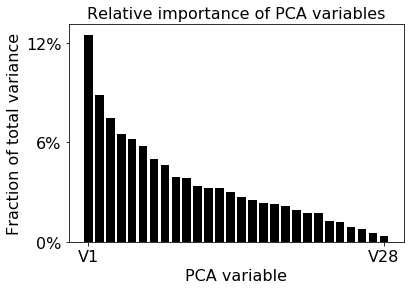

In [5]:
fig = py.figure()
ax = fig.add_subplot(111)
variances = py.diag(covariance_pca)
total_variance = sum(variances)
ax.bar(range(len(variances)),variances/total_variance,width=0.8,color='k')
ax.set_xticks([0,27])
ax.set_xticklabels(['V1','V28'],fontsize=16)
ax.set_xlabel('PCA variable',fontsize=16)
ax.set_yticks([0,0.06,0.12])
ax.set_yticklabels(['0%','6%','12%'],fontsize=16)
ax.set_ylabel('Fraction of total variance',fontsize=16)
ax.set_title('Relative importance of PCA variables',fontsize=16);

The first (most important) PCA variable explains about 12.5% of the variance in data, while the last (least important) variable explains about 0.3% of the variance in data. This does not justify discarding any of the variables.

# Which variables are highly correlated with fraud?
We can consider the strenght of correlation of each variable with the variable we are trying to predict.

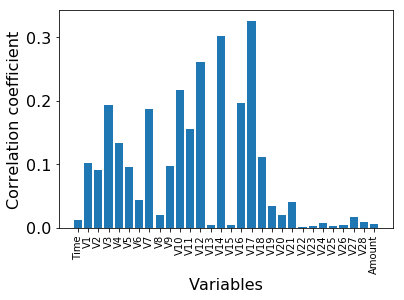

In [6]:
correlation_matrix = dataset.corr()
correlation_var = correlation_matrix.loc['Class',[x for x in correlation_matrix.columns if x!='Class']]
fig = py.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(correlation_var)),abs(correlation_var),width=0.8)
ax.set_xticks(range(len(correlation_var)))
ax.set_xticklabels(correlation_var.index,rotation='vertical')
ax.set_xlabel('Variables',fontsize=16)
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_yticks([0,0.1,0.2,0.3])
ax.set_yticklabels([str(x) for x in ax.get_yticks()],fontsize=16);

Some variables are highly correlated with the variable to predict. This is good news.

# Data visualization
Since the data is already in PCA form, I can visualize them two-at-a-time.

In [16]:
def Data_Visualization(dataset,variableX,variableY,equal=True):
    dataset_valid = dataset[dataset['Class']==0]
    dataset_fraud = dataset[dataset['Class']==1]
    data_x_valid = dataset_valid[variableX]
    data_y_valid = dataset_valid[variableY]
    data_x_fraud = dataset_fraud[variableX]
    data_y_fraud = dataset_fraud[variableY]
    fig = py.figure()
    if equal:
        ax = fig.add_subplot(111,aspect='equal')
    else:
        ax = fig.add_subplot(111)
    ax.scatter(data_x_valid,data_y_valid,marker='.',color='k',label='Valid')
    ax.scatter(data_x_fraud,data_y_fraud,marker='*',color='r',label='Fraud')
    ax.set_xlabel(variableX,fontsize=16)
    ax.set_ylabel(variableY,fontsize=16)
    return fig,ax

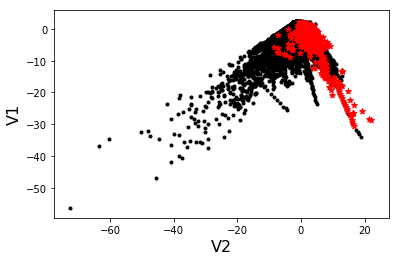

In [8]:
fig,ax = Data_Visualization(dataset,'V2','V1')

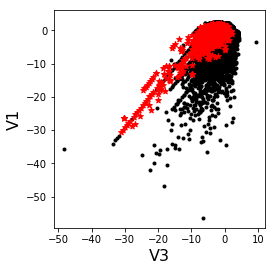

In [9]:
fig,ax = Data_Visualization(dataset,'V3','V1')

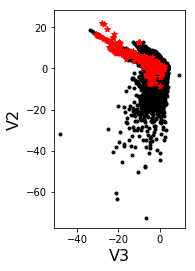

In [10]:
fig,ax = Data_Visualization(dataset,'V3','V2')

These plots are promising. It shows that the fraudulent transactions are concentrated and we can hope to find a rule that can separate them from the valid transactions. At the very least, we see that a simple model using only V1-V2-V3 can already flag many transactions as very likely to be non-fraudulent.

Variables V14 and V17 showed high correlation with the class variable.

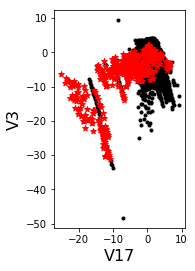

In [11]:
fig,ax = Data_Visualization(dataset,'V17','V3')

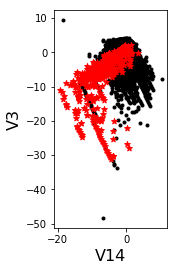

In [12]:
fig,ax = Data_Visualization(dataset,'V14','V3')

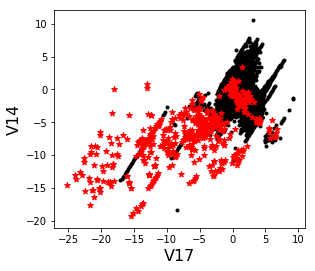

In [13]:
fig,ax = Data_Visualization(dataset,'V17','V14')

# Creating a train and test set
To avoid problems with overfitting, it's important to test a model in a different dataset than it was trained on.

In [70]:
dataset_train,dataset_test = sklearn.model_selection.train_test_split(dataset,test_size=0.2,random_state=0)
features_train = dataset_train.drop('Class',axis=1)
features_test = dataset_test.drop('Class',axis=1)
class_train = dataset_train['Class']
class_test = dataset_test['Class']

In [75]:
sum(class_test)

101

# A simple model - logistic regression
Before trying more 'fancy' models, I will look at a simple logistic regression, to serve as a benchmark. 

In [78]:
logistic_regression = sklearn.linear_model.LogisticRegression(
    fit_intercept = True,
    C = 1.0,
    intercept_scaling = 1
)
logistic_regression.fit(features_train,class_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
proba = logistic_regression.predict_proba(features_test)
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])

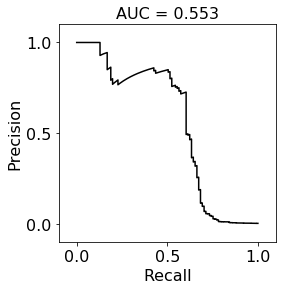

In [80]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall,precision,'k-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('AUC = {:5.3f}'.format(metric),fontsize=16);

# Logistic regression, exploring regularization


In [96]:
estimator = sklearn.linear_model.LogisticRegression()
parameters = {'C':10**(py.linspace(-1,1,10))}
scoring = 'average_precision'
grid = sklearn.model_selection.GridSearchCV(estimator,parameters,scoring)
grid.fit(features_train,class_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  0.1    ,   0.16681,   0.27826,   0.46416,   0.77426,   1.29155,
         2.15443,   3.59381,   5.99484,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

In [97]:
proba = grid.predict_proba(features_test)
precision,recall,threshold = sklearn.metrics.precision_recall_curve(class_test,proba.T[1])
metric = sklearn.metrics.average_precision_score(class_test,proba.T[1])

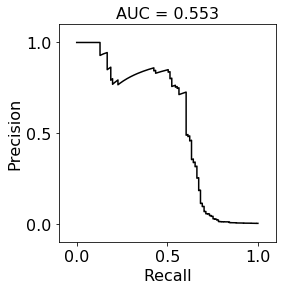

In [98]:
fig = py.figure()
ax = fig.add_subplot(111,aspect='equal')
ax.plot(recall,precision,'k-')
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([str(x) for x in ax.get_xticks()],fontsize=16)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_title('AUC = {:5.3f}'.format(metric),fontsize=16);

In [99]:
grid.cv_results_

{'mean_fit_time': array([ 2.87019857,  2.9621168 ,  2.74734195,  2.71499546,  2.78146791,
         2.80942567,  2.72566239,  2.79563793,  2.79822898,  2.7708873 ]),
 'mean_score_time': array([ 0.03239202,  0.03178771,  0.03105005,  0.03095436,  0.03187323,
         0.03063997,  0.03129331,  0.03247356,  0.02979096,  0.03065936]),
 'mean_test_score': array([ 0.5590327 ,  0.57915357,  0.55974482,  0.55979388,  0.55979938,
         0.55967879,  0.5597569 ,  0.57635979,  0.5594983 ,  0.55954784]),
 'mean_train_score': array([ 0.56669654,  0.59921476,  0.56631896,  0.56613626,  0.56610662,
         0.56565725,  0.56621191,  0.59121595,  0.56581779,  0.56585586]),
 'param_C': masked_array(data = [0.10000000000000001 0.16681005372000587 0.27825594022071243
  0.46415888336127786 0.774263682681127 1.2915496650148841
  2.1544346900318834 3.5938136638046259 5.9948425031894086 10.0],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'para

In [128]:
ppr = [(x,y) for x,y in zip(pr,class_test)]
ppr_z = [x[0] for x in ppr if x[1]==0]
ppr_o = [x[0] for x in ppr if x[1]==1]
print(py.array(ppr_z).mean(),py.array(ppr_z).std(),len(ppr_z))
print(py.array(ppr_o).mean(),py.array(ppr_o).std(),len(ppr_o))

0.99617943008 0.0247094770373 56861
0.424500520521 0.446477566801 101


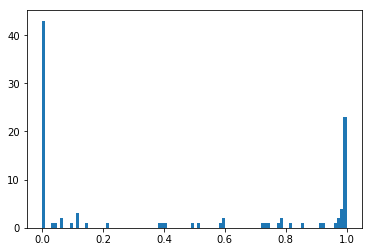

In [133]:
fig,ax = py.subplots()
ax.hist(ppr_o,bins=100);

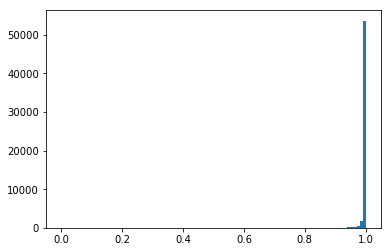

In [134]:
fig,ax = py.subplots()
ax.hist(ppr_z,bins=100);

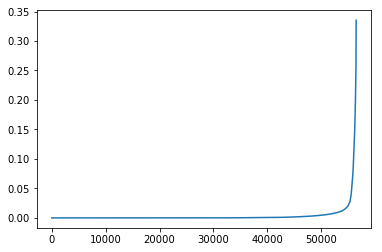

In [161]:
fig,ax = py.subplots()
ax.plot(threshold[:-100])

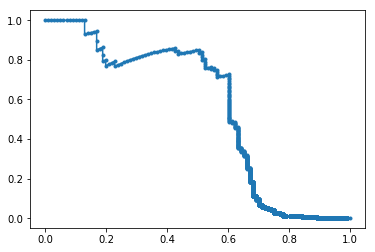

In [165]:
fig,ax = py.subplots()
ax.plot(recall[:],precision[:],'.-')

In [152]:
len(recall)

56592